### Tool for plotting UV-Vis spectra from excel sheets originiating from Tecan Safire II in Wilcox 133
Author: John Hamann  
Contact: hamann3@uw.edu  
Data: 12/30/2021

#### Step 1: Import excel sheet
1. Move desired excel sheet to the same directory as this file
2. Rename variables filename and sheet below accordingly

In [138]:
import pandas as pd

filename = 'example1.xls'
sheet = 'Sheet1'

#Create pandas dataframe
df = pd.read_excel(filename,sheet)

#### 2: Extract Metadata

In [139]:
#Get key metadata from the fist 18 rows of the excel sheet

metaData = {}
for i in range(18):
    metaData[df.iloc[i,0]] = df.iloc[i,5]

wavelengthStart = metaData['Wavelength start:']
wavelengthEnd = metaData['Wavelength end:']
wavelengthRange = wavelengthEnd - wavelengthStart

#Note: metadata format in excel sheet changes depending on initial set up of measurement

if 'Number of kinetic cycles:' in metaData:
    numberOfCycles = metaData['Number of kinetic cycles:']
else:
    numberOfCycles = 1    
    
#Gets actual number of cycles based on available data rather than metadata 
for i in range(wavelengthRange+100):
    if type(df.iloc[-i,0]) is str:
        if df.iloc[-i,0].startswith('Cycle Number:'):
            numberOfCycles = int(df.iloc[-i,0].split()[2])
            break

if 'Kinetic interval:' in metaData:
    cycleInterval = int(metaData['Kinetic interval:'])
elif 'Kinetic interval (Minimal):' in metaData:
    cycleInterval = int(metaData['Kinetic interval (Minimal):'])
else:
    cycleInterval = 0
    
print('Wavelength Start: ', wavelengthStart)
print('Wavelength End: ', wavelengthEnd)
print('Number of cycles: ', numberOfCycles) 
print('Cycle interval (s): ', cycleInterval)

Wavelength Start:  230
Wavelength End:  1000
Number of cycles:  49
Cycle interval (s):  2303


#### Step 3: Identify measurment wells and data indices

In [140]:
dataGap = 16
startIndex = 0

#Find the starting index

for n in range(50):
    if df.iloc[n,0] == wavelengthStart:
        startIndex = n
        break
        
endIndex = startIndex + wavelengthRange + 1

wells = [w for w in df.iloc[startIndex-1].values.tolist()
         if (str(w) != 'nan' and str(w) != 'WaveLength:')]

print('Spectra Found in the following wells:', wells)
print('Start Index:', startIndex)
print('End Index:', endIndex)

Spectra Found in the following wells: ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3', 'A4', 'A5', 'A6']
Start Index: 32
End Index: 803


#### Step 4: Import absorption data per well per cycle
Variable 'collection' is a python dictionary with the well location as the key corresponding to UV-Vis absorption data (per cycle)

In [141]:
# Get absorption array per well per cycle

import numpy as np

collection = {}

i = 1
for w in wells:
    sI = startIndex
    eI = endIndex
    data = np.array(df.iloc[sI:eI].values.tolist())[:,0]
    
    for n in range(numberOfCycles):
        data = np.column_stack((data, np.array(df.iloc[sI:eI].values.tolist())[:,i]))
        sI = sI + wavelengthRange + dataGap
        eI = sI + wavelengthRange + 1
    
    collection[w] = data
    
    i = i + 1

#### Step 5: Plot UV-Vis Spectra
1. Change 'well' variable to desired plate location  

**Note: If you get a *Key Error* that means you have specified a well not in the current dataset**

Text(0.5, 1.0, 'A1 UV-Vis Spectra ')

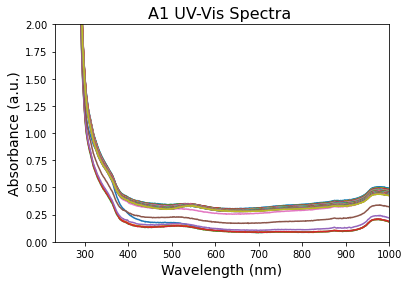

In [142]:
import matplotlib.pyplot as plt

# Plot time series data for a specific well

well = 'A1'

ylim = [0,2] 
xlim = [wavelengthStart,wavelengthEnd]


#xlim = [300,400]

ex = collection[well]

#Plots each absorption spectra for each cycle
for n in range(numberOfCycles): 
    plt.plot(ex[:,0],ex[:,(n+1)])
    

plt.ylim(ylim)
plt.xlim(xlim)

#plt.legend(fontsize=10, loc='upper right')
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Absorbance (a.u.)', fontsize=14)
plt.title(well + ' UV-Vis Spectra ', fontsize=16)


#### Step 6: Plot absorption for a specific wavelength for a specific well

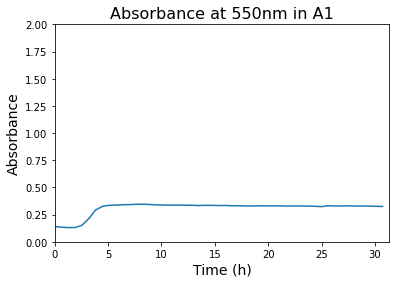

In [150]:
# Plot time series data for each well and wavelength over time
well = 'A1'
wavelength = 550 #nm

ylim = [0,2] 
xlim = [0,numberOfCycles*cycleInterval/3600]

if numberOfCycles == 1:
    #Just print the absorbance measurement if there's only one spectra available
    ex = collection[well]
    print('Absorbance at ' + str(wavelength) + 'nm is : ' + str(ex[wavelength-230,1]))
else:
    
    ex = collection[well]
    temp_array = np.zeros((numberOfCycles,2))
    
    for n in range(numberOfCycles): 
        temp_array[n,0] = (n*cycleInterval/3600)
        temp_array[n,1] = ex[wavelength-230,n+1]
    
    plt.plot(temp_array[:,0],temp_array[:,1])
    
    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.xlabel('Time (h)', fontsize=14)
    plt.ylabel('Absorbance', fontsize=14)
    plt.title('Absorbance at ' + str(wavelength) + 'nm'+ ' in ' + well,fontsize=16)

#### Step 7: Plot temperature profile

min: 24.4 max:  26.3 avg: 25.71


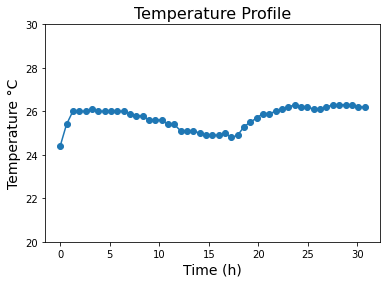

In [149]:
# Get temperature
tempDf = df[df.iloc[:,0] == 'Rawdata']
tempList = tempDf.iloc[:,5].values.tolist()
tempArray = np.ndarray(shape=(0,0))
for t in tempList:
    tempArray = np.append(tempArray, float(t.split()[1]))
    
# Get time
timeDf = df[df.iloc[:,5] == 'Elapsed time after first cycle:']
timeList = timeDf.iloc[:,8].values.tolist()
timeArray = np.insert(np.array(timeList), 0, 0)/3600
    
# Plot
plt.plot(timeArray,tempArray, '-o')
plt.ylim([20,30])

plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Temperature °C', fontsize=14)
plt.title("Temperature Profile", fontsize=16)

print('min:', min(tempArray), 'max: ', max(tempArray), 'avg:', round(tempArray.mean(),2))

#### Bonus: Plot absorption for a specific wavelength for multiple wells

Text(0.5, 1.0, 'Absorbance at 550nm in A3')

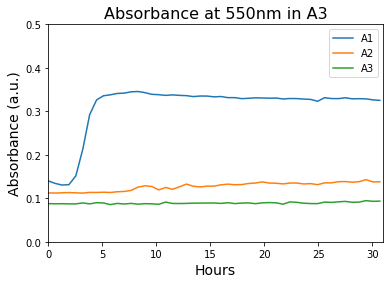

In [147]:
# Plot time series data for each well and wavelength over time

wells = ['A1', 'A2', 'A3']
#wells = ['C1', 'C2', 'C3']
wavelength = 550

legend_entries = ['A1', 'A2', 'A3']

for w in wells:
    ex = collection[w]
    temp_array = np.zeros((numberOfCycles,2))
    for n in range(numberOfCycles): 
        temp_array[n,0] = (n*cycleInterval/3600)
        temp_array[n,1] = ex[wavelength-230,n+1]
    
    plt.plot(temp_array[:,0],temp_array[:,1])
    
    
plt.xlim([0,31])
plt.ylim([0,0.5])
plt.legend(legend_entries,fontsize=10, loc='upper right')
plt.xlabel('Hours', fontsize=14)
plt.ylabel('Absorbance (a.u.)', fontsize=14)
plt.title('Absorbance at ' + str(wavelength) + 'nm'+ ' in ' + well,fontsize=16)

#### Bonus: Comparing spectra of multiple wells 

Text(0.5, 1.0, 'Final spectra of 3 different wells')

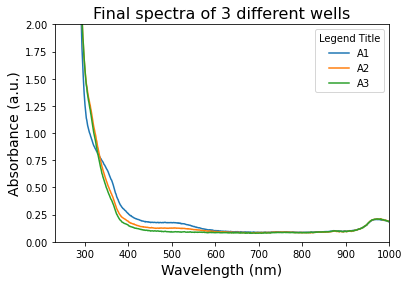

In [146]:
ylim = [0,2] 
xlim = [wavelengthStart,wavelengthEnd]

index = -1 # t=end
#index = 1 # t=start

well = 'A1'
ex = collection[well]
plt.plot(ex[:,0],ex[:,index])

well = 'A2'
ex = collection[well]
plt.plot(ex[:,0],ex[:,index])

well = 'A3'
ex = collection[well]
plt.plot(ex[:,0],ex[:,index])

legend_entries = ['A1', 'A2' , 'A3']
plt.legend(legend_entries,fontsize=10, loc='upper right', title = 'Legend Title')

plt.ylim(ylim)
plt.xlim(xlim)

plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Absorbance (a.u.)', fontsize=14)

plt.title( 'Final spectra of 3 different wells', fontsize=16)